In [12]:
## Post processing the result
## Evaluate the results 
## Visualise the result

In [13]:
## evaluate the results


In [14]:
%matplotlib inline 
import os,sys,shutil,cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


In [15]:
def precision(gt_mask,pred_mask):
    return (np.sum(gt_mask & pred_mask) / np.sum(pred_mask))

def recall(gt_mask,pred_mask):
    return (np.sum(gt_mask & pred_mask) / np.sum(gt_mask))

def iou(gt_mask,pred_mask):
    return (np.sum(gt_mask & pred_mask) / np.sum(gt_mask | pred_mask))


def dice_score(gt_mask,pred_mask):
    if (np.sum(gt_mask) + np.sum(pred_mask)) ==0:
        return 0
    else:
    
        return 2* (np.sum(gt_mask & pred_mask) / (np.sum(gt_mask) + np.sum(pred_mask)))

def remove_inner_bone_area(goal_mask,ori_mask, cc_threshold_pixels = 0):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(goal_mask)

    # Create an array to hold the connected component masks
    # masks = np.zeros((num_labels - 1, mask.shape[0], mask.shape[1]), dtype=np.uint8)
    masks = []
    # Loop through each connected component and extract its mask
    for i in range(1, num_labels):
        component_mask = np.zeros(goal_mask.shape, dtype=np.uint8)
        component_mask[labels == i] = 255
        component_size = stats[i, cv2.CC_STAT_AREA]
        if component_size >= cc_threshold_pixels:
            masks.append(component_mask)

    # print("number of connected component:" , len(masks))
    not_in_bone_masks = []
    for cc in masks:
        # cc = masks[8]
        size = 3
        idxs = np.where(cc ==255)

        neighbors_all = []
        for row,col in zip(idxs[0],idxs[1]) :
            
            # print(type(row),col)
            # Extract the rectangular region around the pixel
            subimg = cv2.getRectSubPix(ori_mask, (size,size) , (int(col),int(row)))

            # Get the neighboring pixels as a 1D array
            neighbors = subimg.flatten()

            # Remove the center pixel from the array of neighboring pixels
            neighbors = np.delete(neighbors, size**2//2)
            neighbors_all = np.concatenate((neighbors_all , neighbors))
        # print("not inside: ",np.any(neighbors_all==0))
        if np.any(neighbors_all==0):
            not_in_bone_masks.append(cc)
            
    return not_in_bone_masks

def refine_with_not_in_bone_masks(mask, not_in_bone_masks, class_value):
    mask_temp = mask.copy()
    mask_temp[mask ==class_value]=0

    for not_in_bone_mask in not_in_bone_masks:
        mask_temp[not_in_bone_mask ==255]=class_value

    return mask_temp

    # for not_in_bone_mask in not_in_bone_masks:
    #     mask[not_in_bone_mask ==255]=2

    # # print(len(masks))
    # # plt.imshow(masks[8])
    # plt.figure()
    # plt.imshow(mask)

In [ ]:
## visualisation 
## 1 class classification using the true positive, false positive an false negative
## or multiple classification
## Image the overlaid version

def visualise_mask(img, gt_mask , pred_mask , alpha=0.3):
    n_classes= np.unique(gt_mask)

    if len(n_classes)==2:
        tp = (pred_mask==1) & (gt_mask==1)
        fp = (pred_mask==1) & (gt_mask==0)
        fn = (pred_mask==0) & (gt_mask==1)

        overlay_mask = np.zeros_like(img)
        overlay_mask[tp] = (0, 255,0 ) # set the color of the mask (here, red)
        overlay_mask[fp] = (0, 0,255 ) # set the color of the mask (here, red)
        overlay_mask[fn] = (255, 0,0 ) # set the color of the mask (here, red)
        # # apply the mask to the image
        result = cv2.addWeighted(img, 1 - alpha, overlay_mask, alpha, 0)
        return result
    else:
        colours = [(0, 255,0 ) , (0, 0,255 ) , (255, 0,0 ) , 
                   (255, 255,0 ) , (255, 0,255 ), (0, 255,255 )]
        overlay_mask = np.zeros_like(img)
        for i,i_c in enumerate(n_classes):
            overlay_mask[pred_mask ==i_c] = colours[i]
        result = cv2.addWeighted(img, 1 - alpha, overlay_mask, alpha, 0)
        return result

def visualise_masks_from_dir(img_dir, gt_mask_dir , pred_mask_dir , output_dir):
    files = os.listdir(img_dir)
    for file in files:
        img = cv2.imread(os.path.join(img_dir,file))
        pred_mask = cv2.imread(os.path.join(pred_mask_dir,file), cv2.IMREAD_GRAYSCALE)
        gt_mask = cv2.imread(os.path.join(gt_mask_dir,file), cv2.IMREAD_GRAYSCALE)
        output = visualise_mask(img, gt_mask , pred_mask )
        print(output.shape)
        cv2.imwrite(os.path.join(output_dir , file) , output)

img_dir = "./data/suture_demo_data/cy_img"
gt_mask_dir = "./data/suture_demo_data/cy_mask"
pred_mask_dir = "./output/suture_demo_cy/"
output_dir = "vis/"

        
visualise_masks_from_dir(img_dir, gt_mask_dir , pred_mask_dir , output_dir)       


In [ ]:
## post_process the masks ##
# Use predicted bones which should be more accurately predicted
# To updated the sutures, which can often have the suture location correctly, but having thicker area than the actual one
# Use the bones to refine the suture predictions

mask_dir = "result/type1/"

bone_mask_dir = "result/type1_bone/"

gt_mask_dir = "result/mask_crop/"
# new_dir= "data/training_suture/mask/"
# Path(new_dir).mkdir(parents=True, exist_ok=True)

files = os.listdir(mask_dir)
iou_results = np.zeros((len(files),3))
for idx, file in enumerate(files):
    mask = cv2.imread(os.path.join(mask_dir , file), cv2.IMREAD_GRAYSCALE )
    

    
    gt_mask = cv2.imread(os.path.join(gt_mask_dir , file), cv2.IMREAD_GRAYSCALE)
    
    bone_mask = cv2.imread(os.path.join(bone_mask_dir , file), cv2.IMREAD_GRAYSCALE)
    
    new_mask = mask.copy()
    
    new_mask[bone_mask==1] =1
    
    
    not_in_holes = remove_inner_bone_area((new_mask == 2).astype('uint8'),new_mask ,10)
    not_in_holes_result = refine_with_not_in_bone_masks(new_mask,not_in_holes,class_value=2)
    
    
    iou_results[idx , 0] = dice_score(gt_mask == 2, mask == 2)
    iou_results[idx , 1] = dice_score(gt_mask == 2, new_mask == 2)
    iou_results[idx , 2] = dice_score(gt_mask == 2, not_in_holes_result == 2)
    
    fig = plt.figure(figsize=(15, 5), dpi=200)

    

    ax1 = fig.add_subplot(1, 4, 1)  # equivalent but more general
    ax1.axis('off')
    ax1.imshow(gt_mask)
    
    ax1 = fig.add_subplot(1, 4,2)  # equivalent but more general
    ax1.axis('off')
    ax1.imshow(mask)
    
    ax1 = fig.add_subplot(1, 4, 3)  # equivalent but more general
    ax1.axis('off')
    ax1.imshow(new_mask)


    ax1 = fig.add_subplot(1, 4, 4)  # equivalent but more general
    ax1.axis('off')
    ax1.imshow(not_in_holes_result)
    
    # if old_values is None or new_values is None:
    #     old_values = np.unique(mask)
    #     new_values = list(range(0, len(old_values)))
    
    plt.savefig("plots/{}.png".format(idx))

plt.violinplot(iou_results)


{'bodies': [<matplotlib.collections.PolyCollection at 0x20780231d20>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x20780232740>,
 'cmins': <matplotlib.collections.LineCollection at 0x207802326b0>,
 'cbars': <matplotlib.collections.LineCollection at 0x207802339d0>}

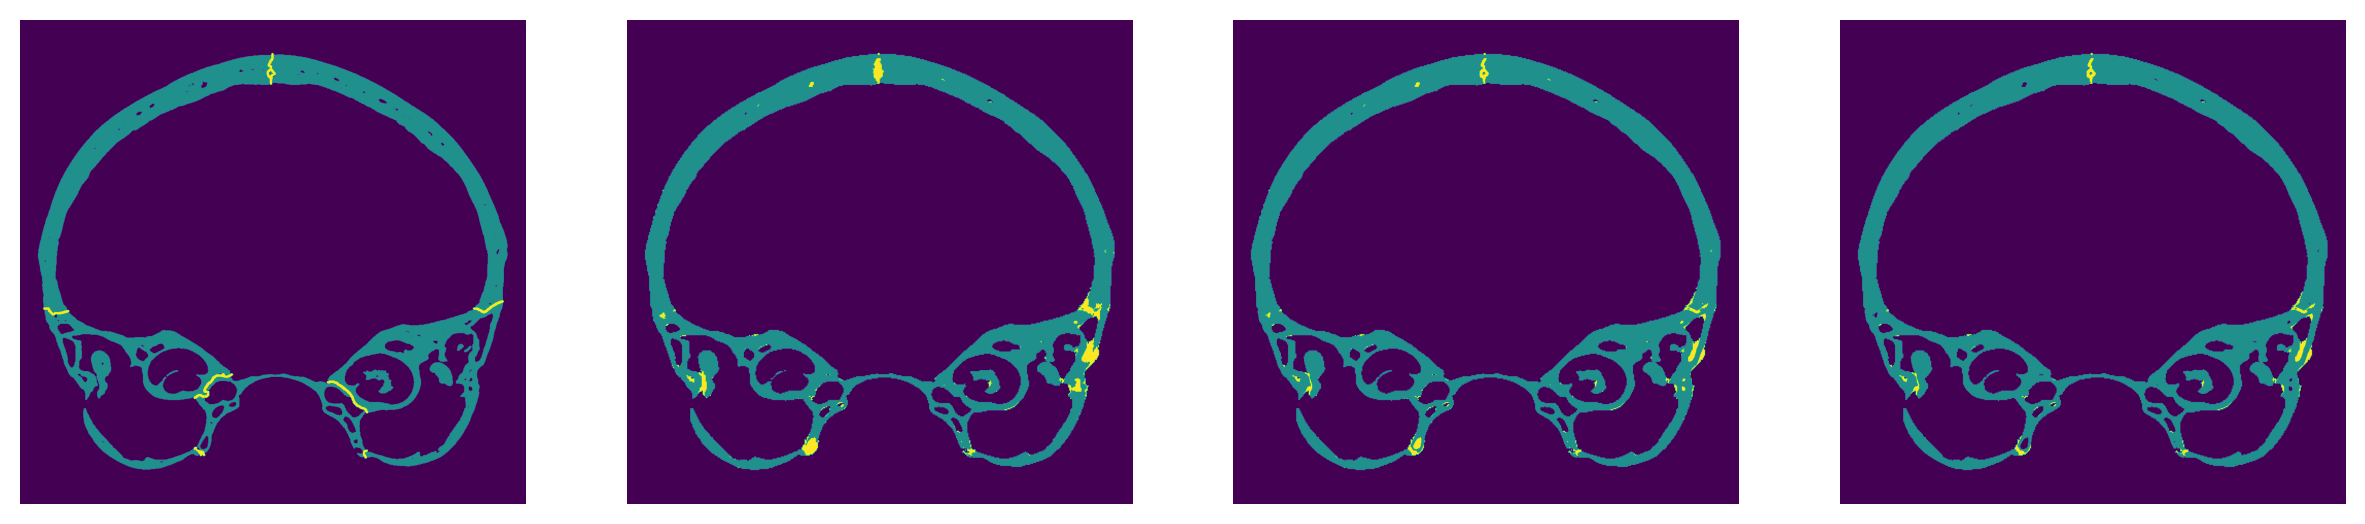

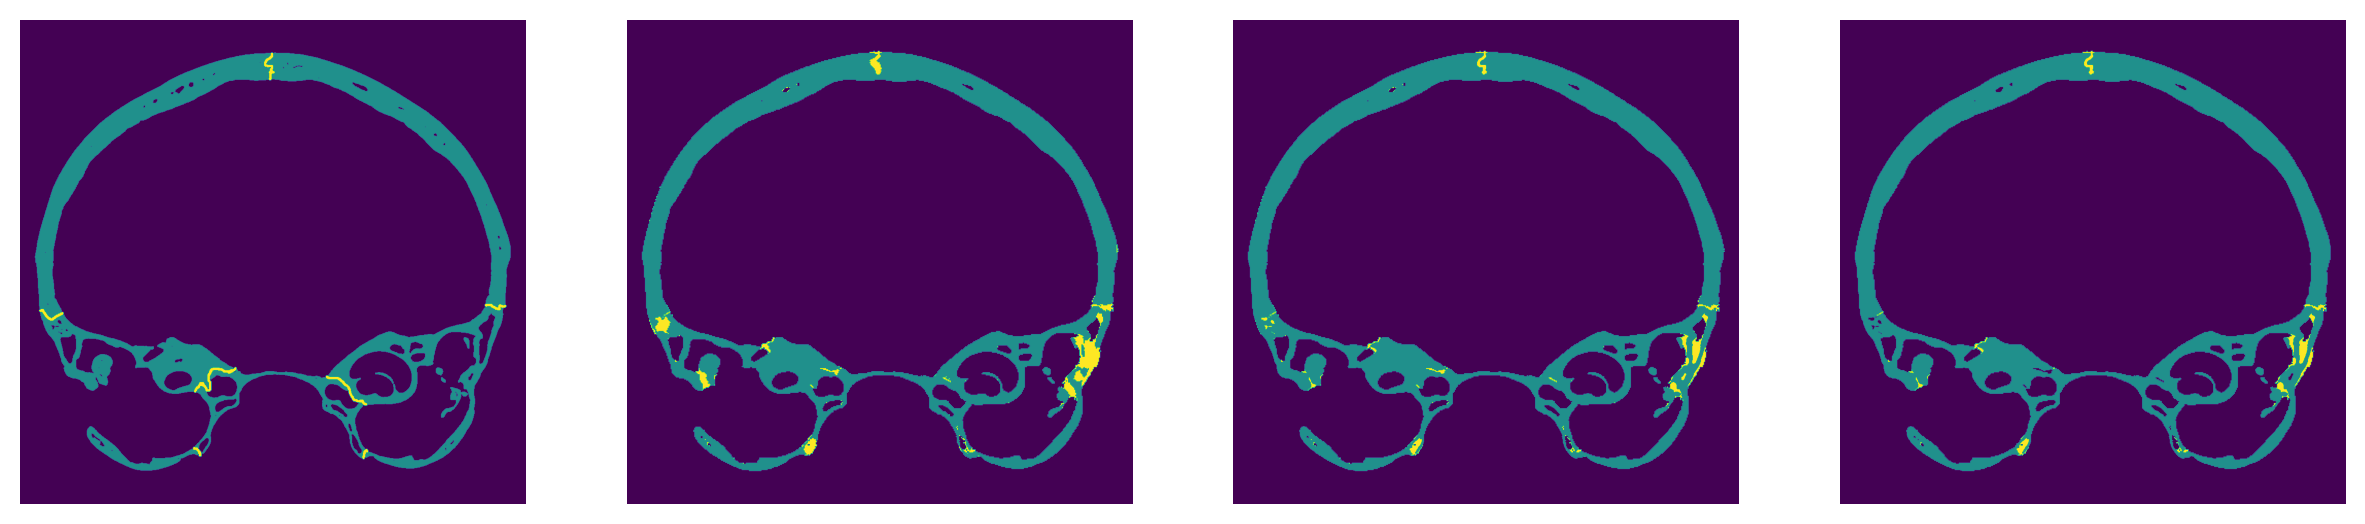

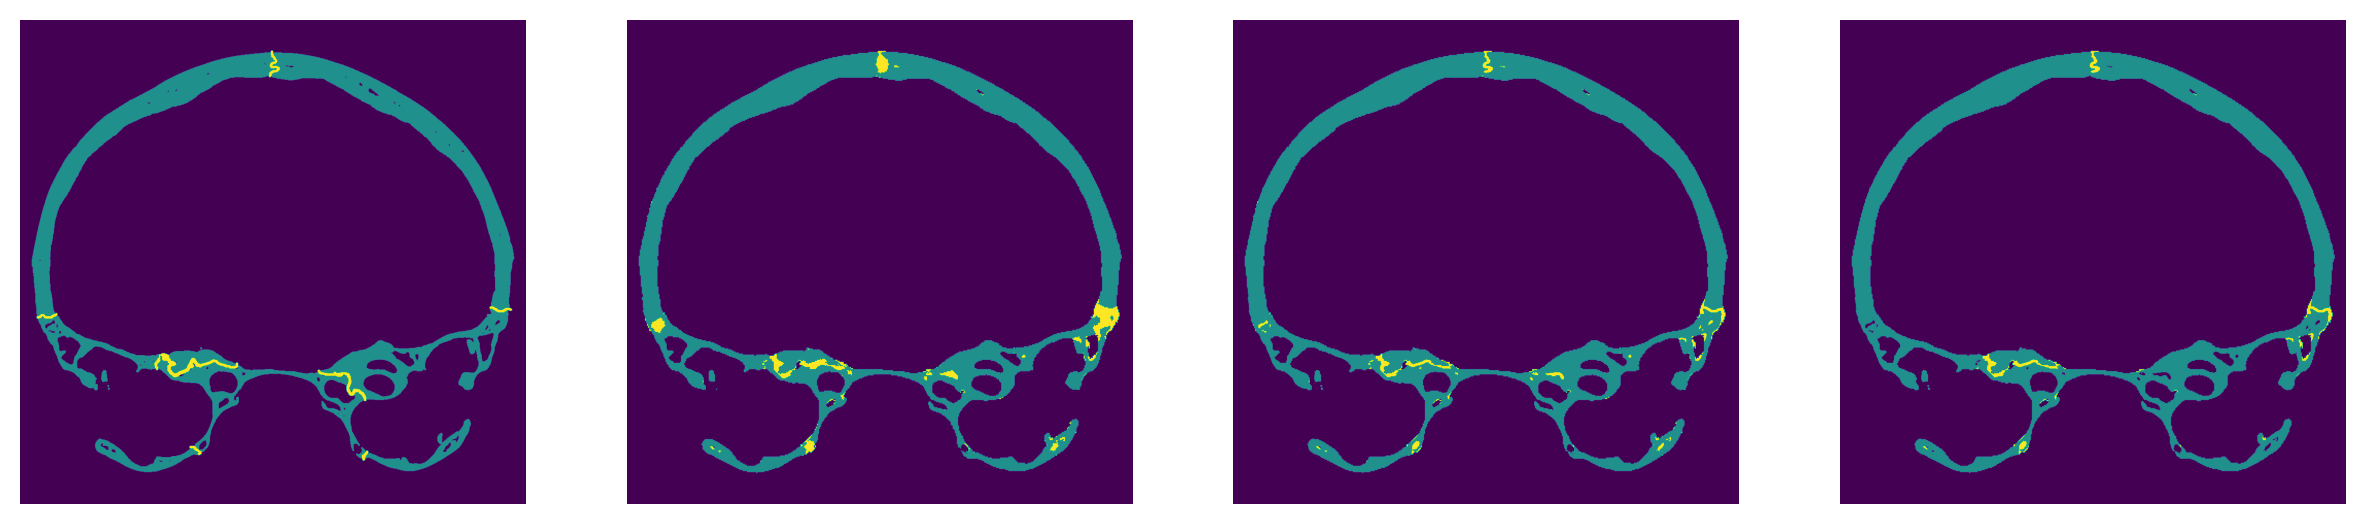

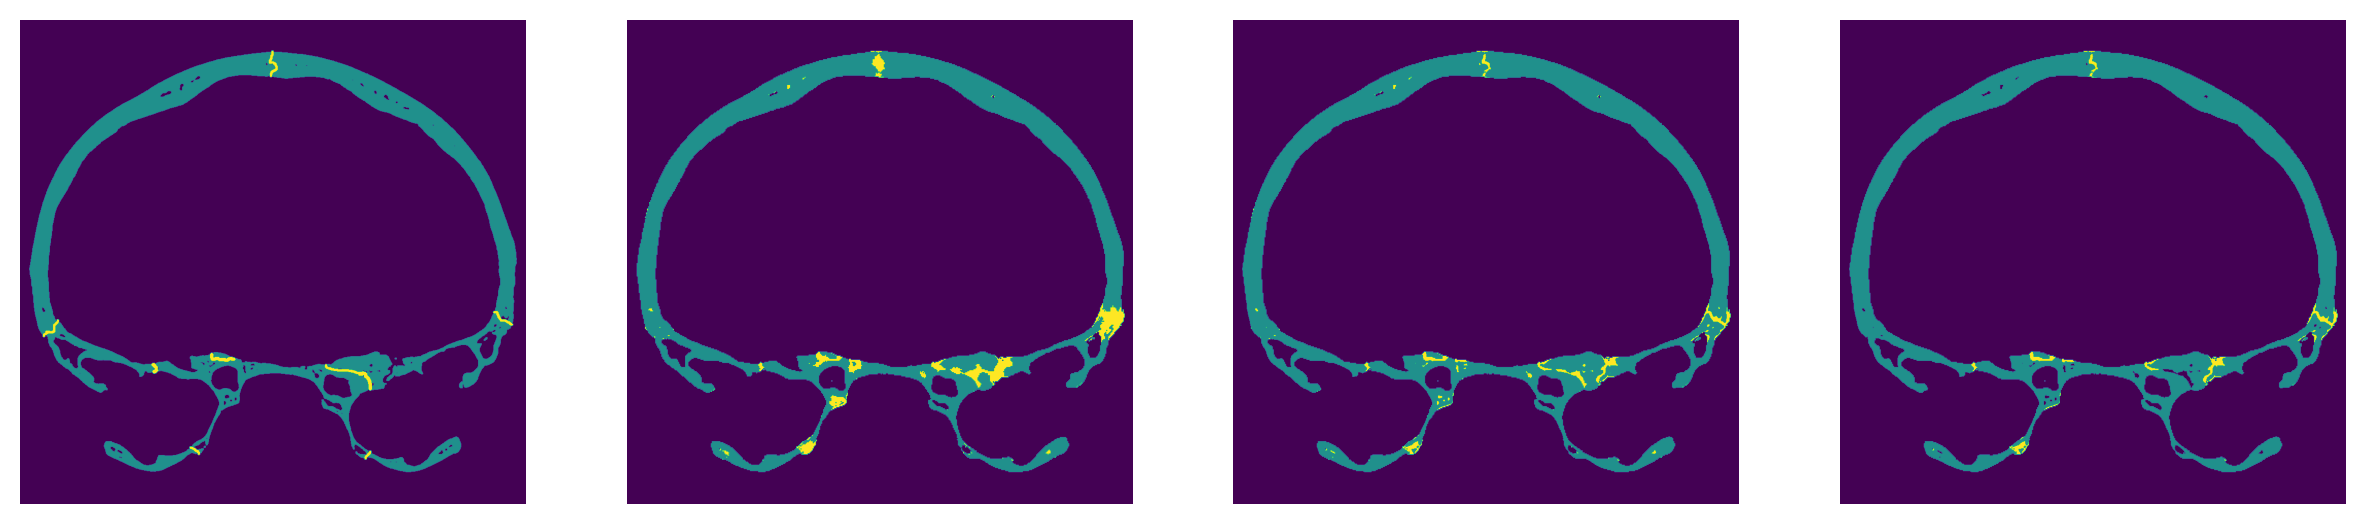

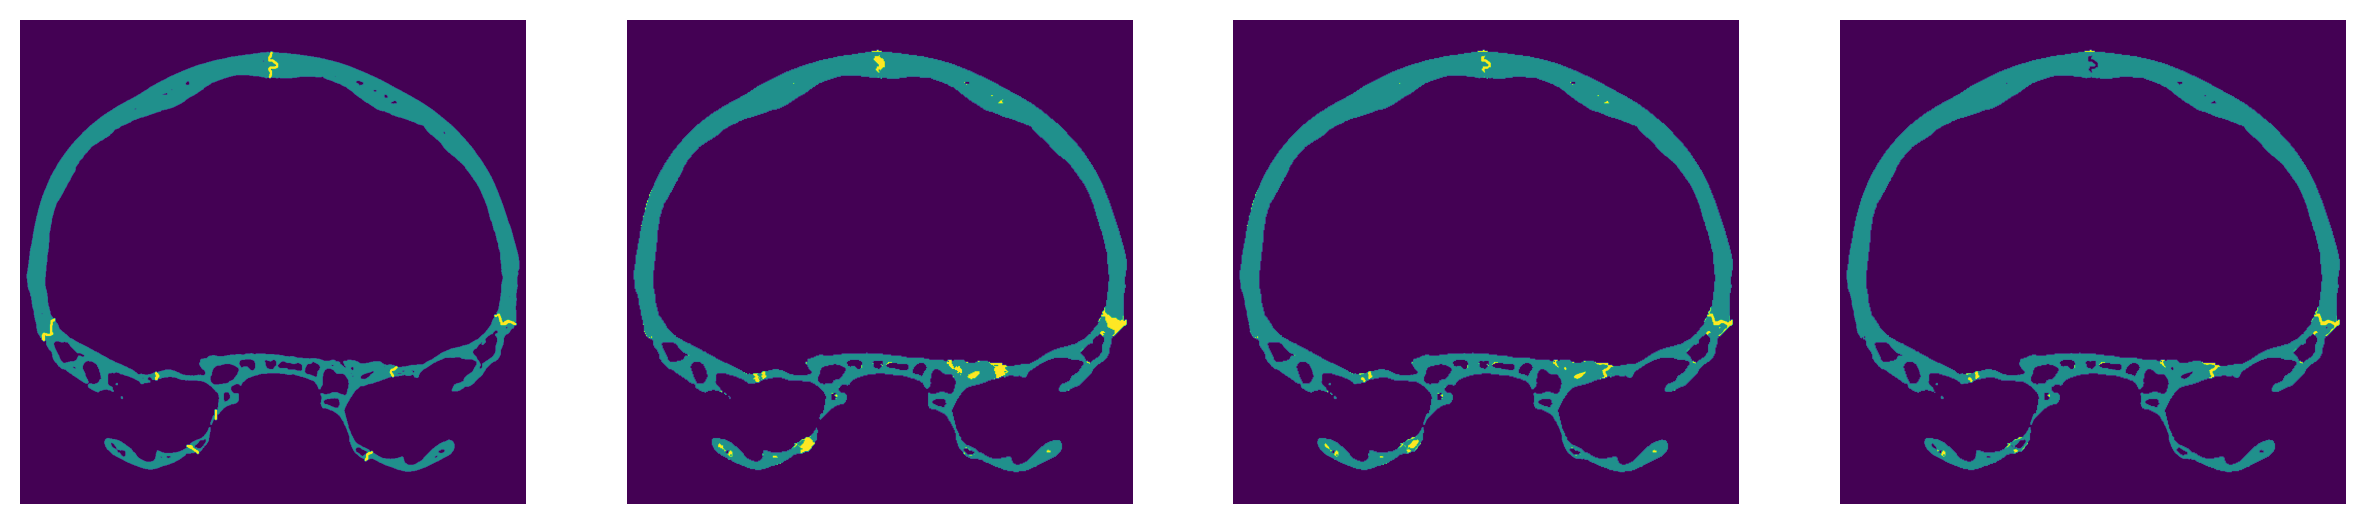

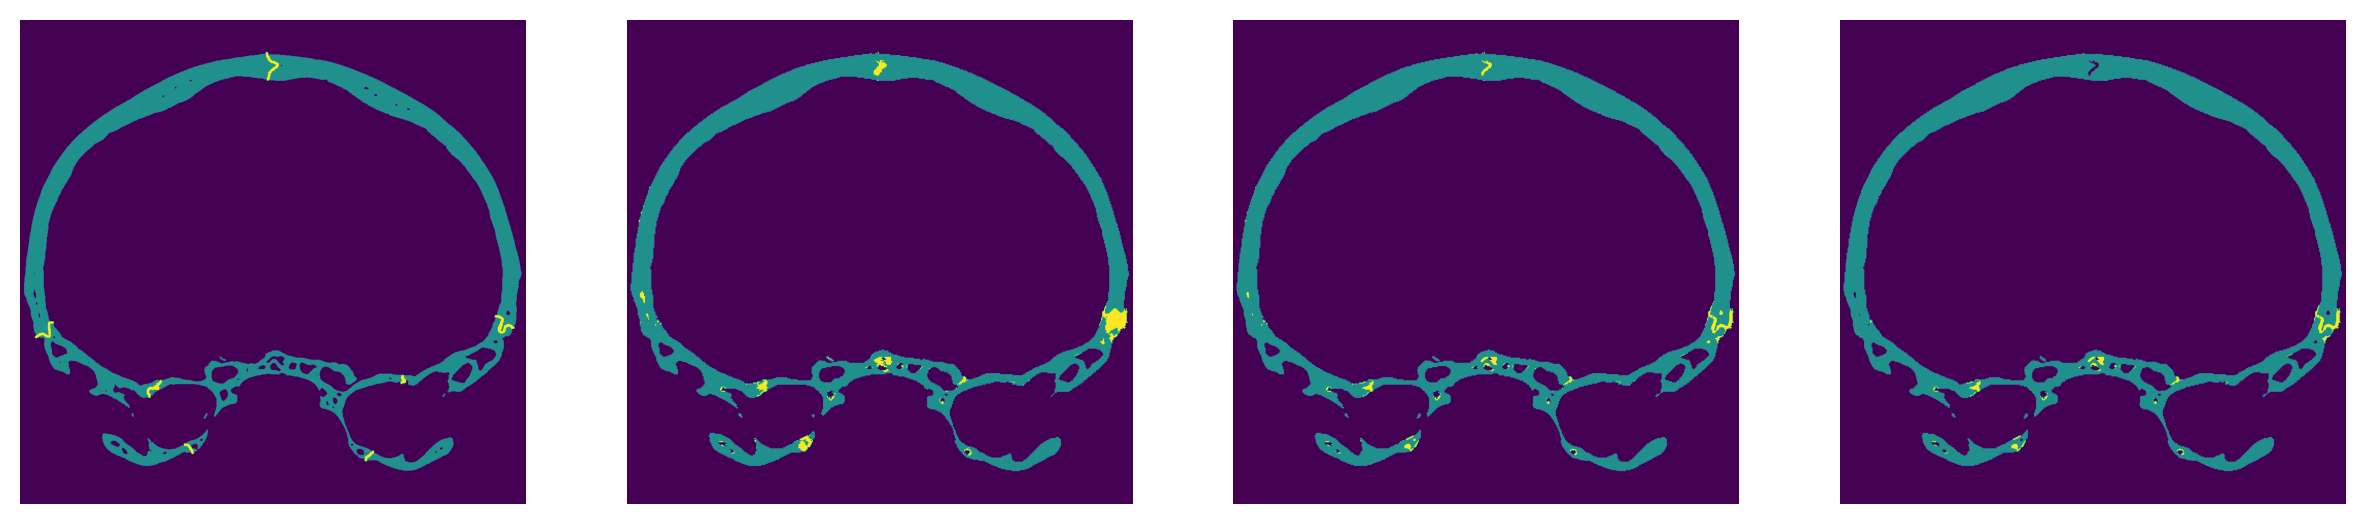

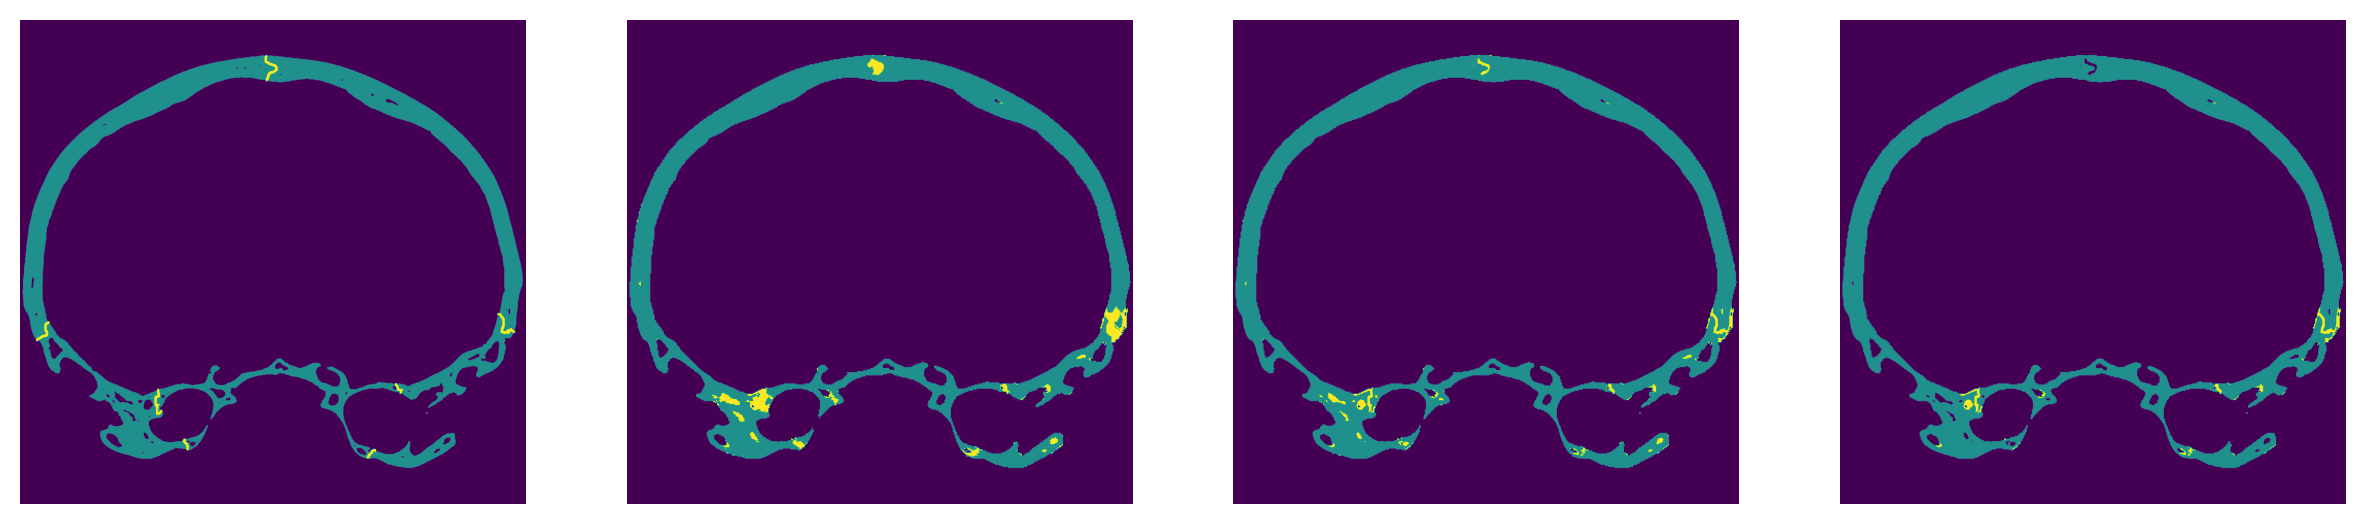

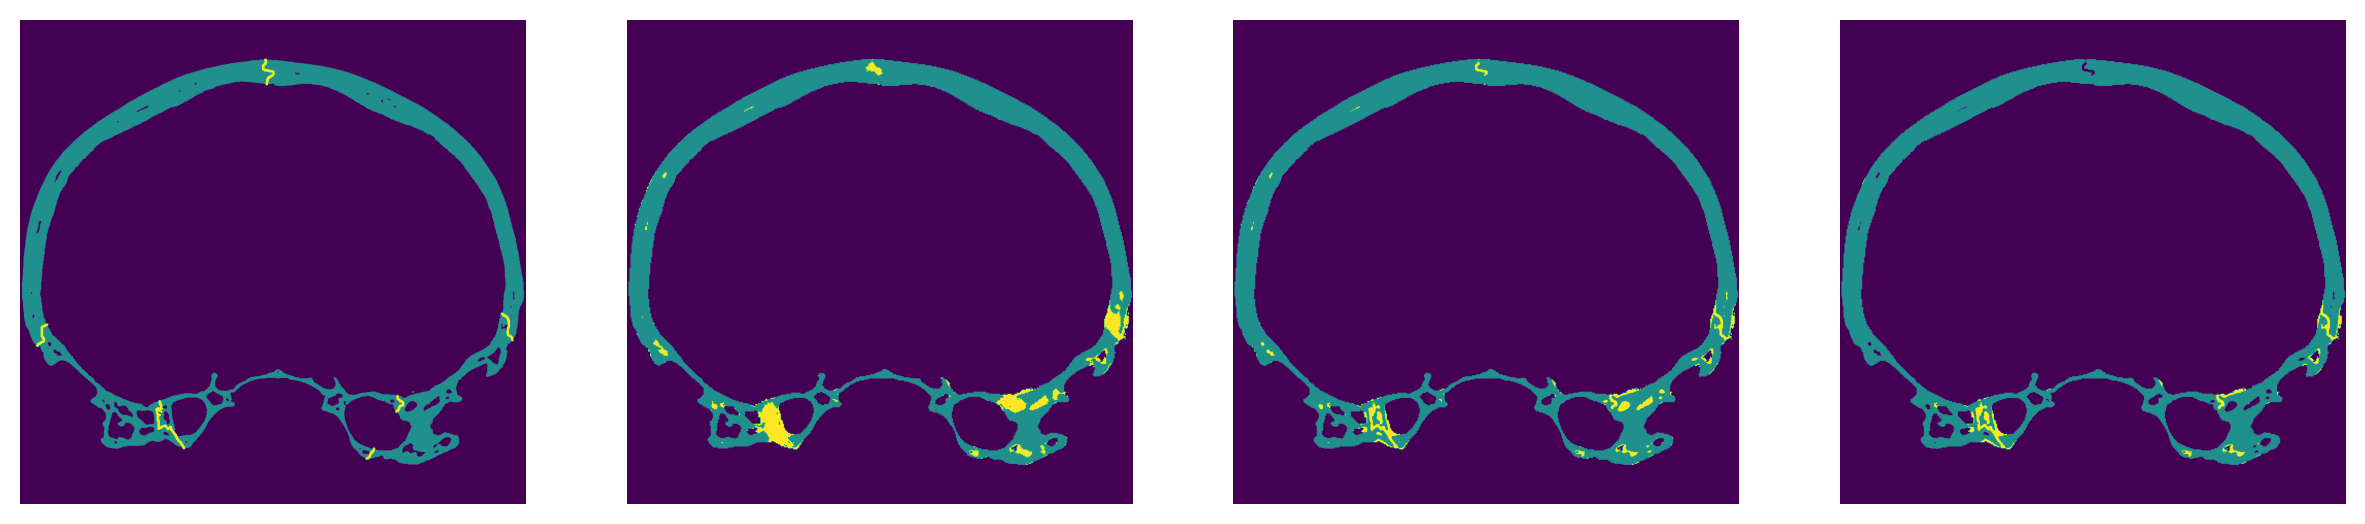

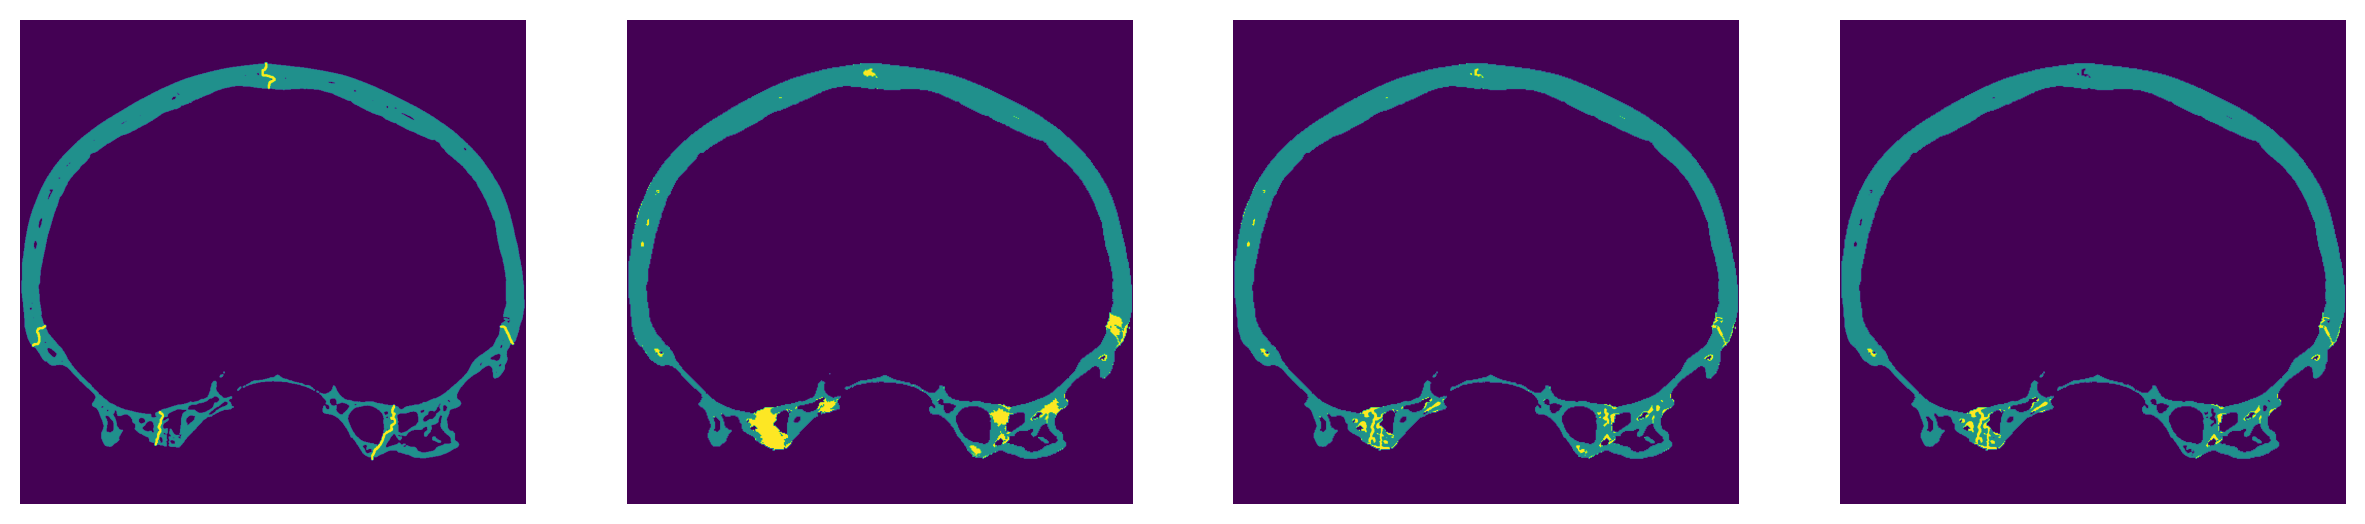

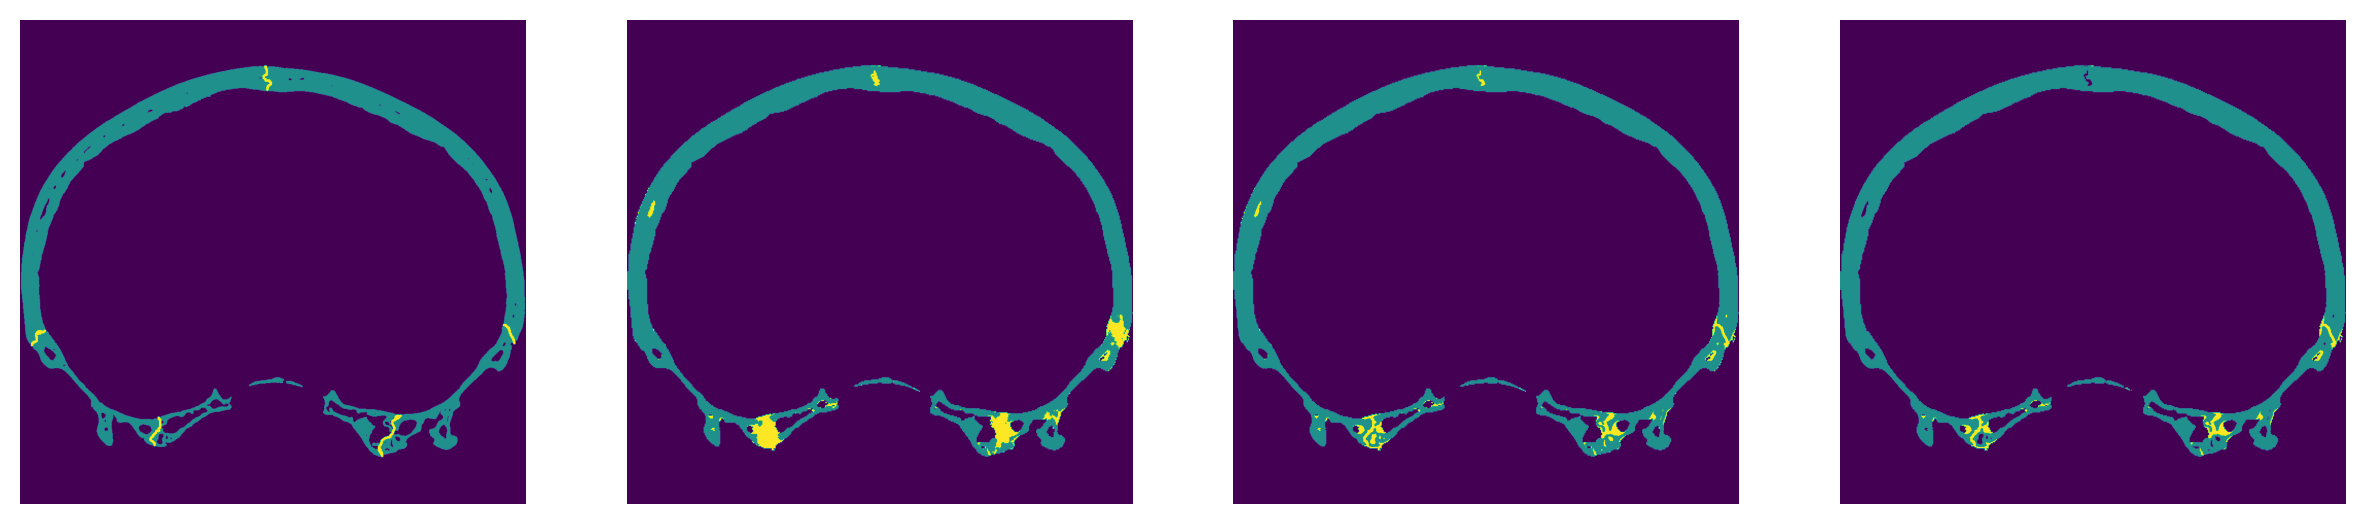

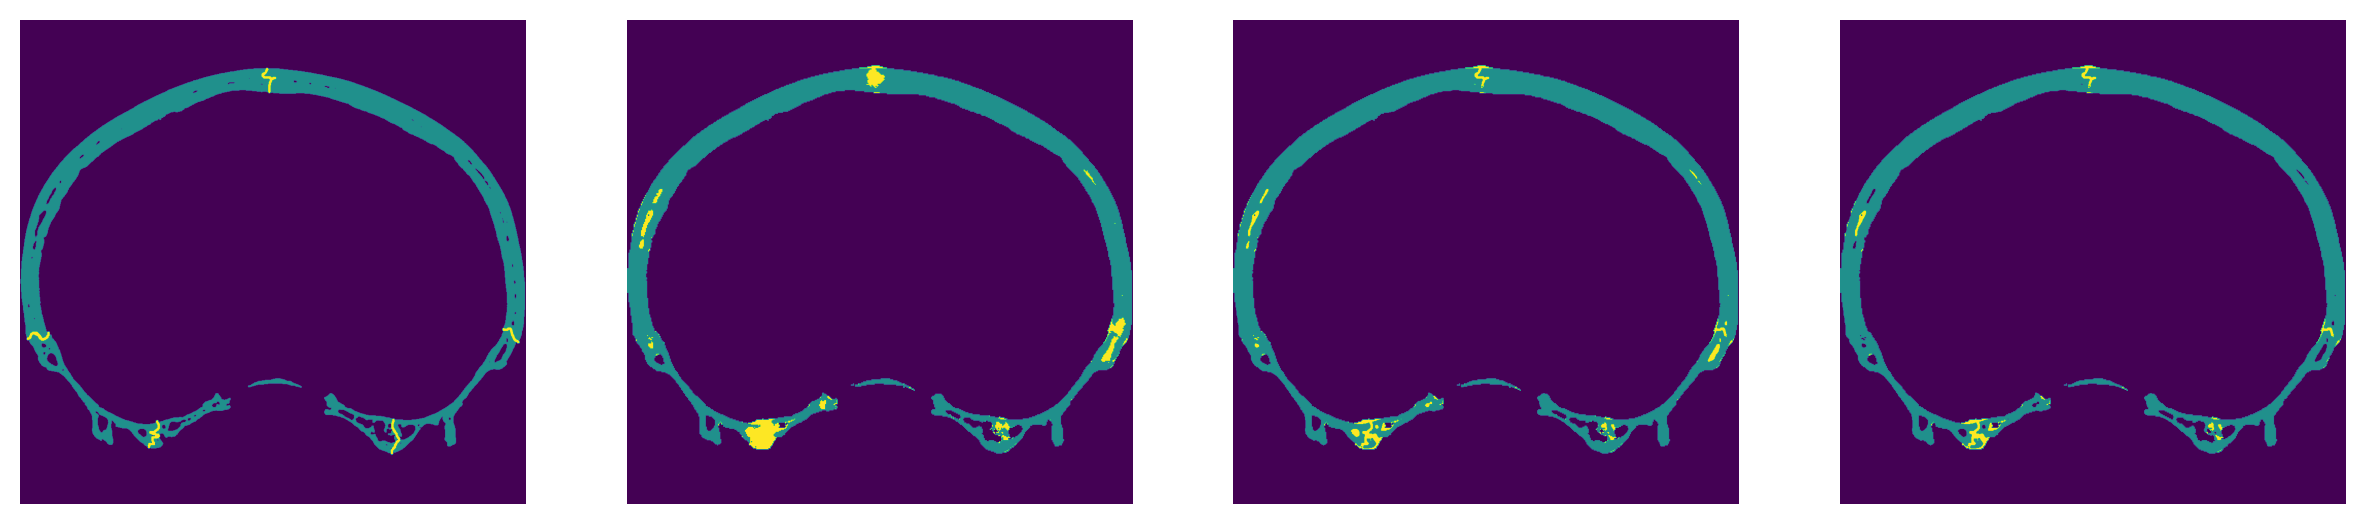

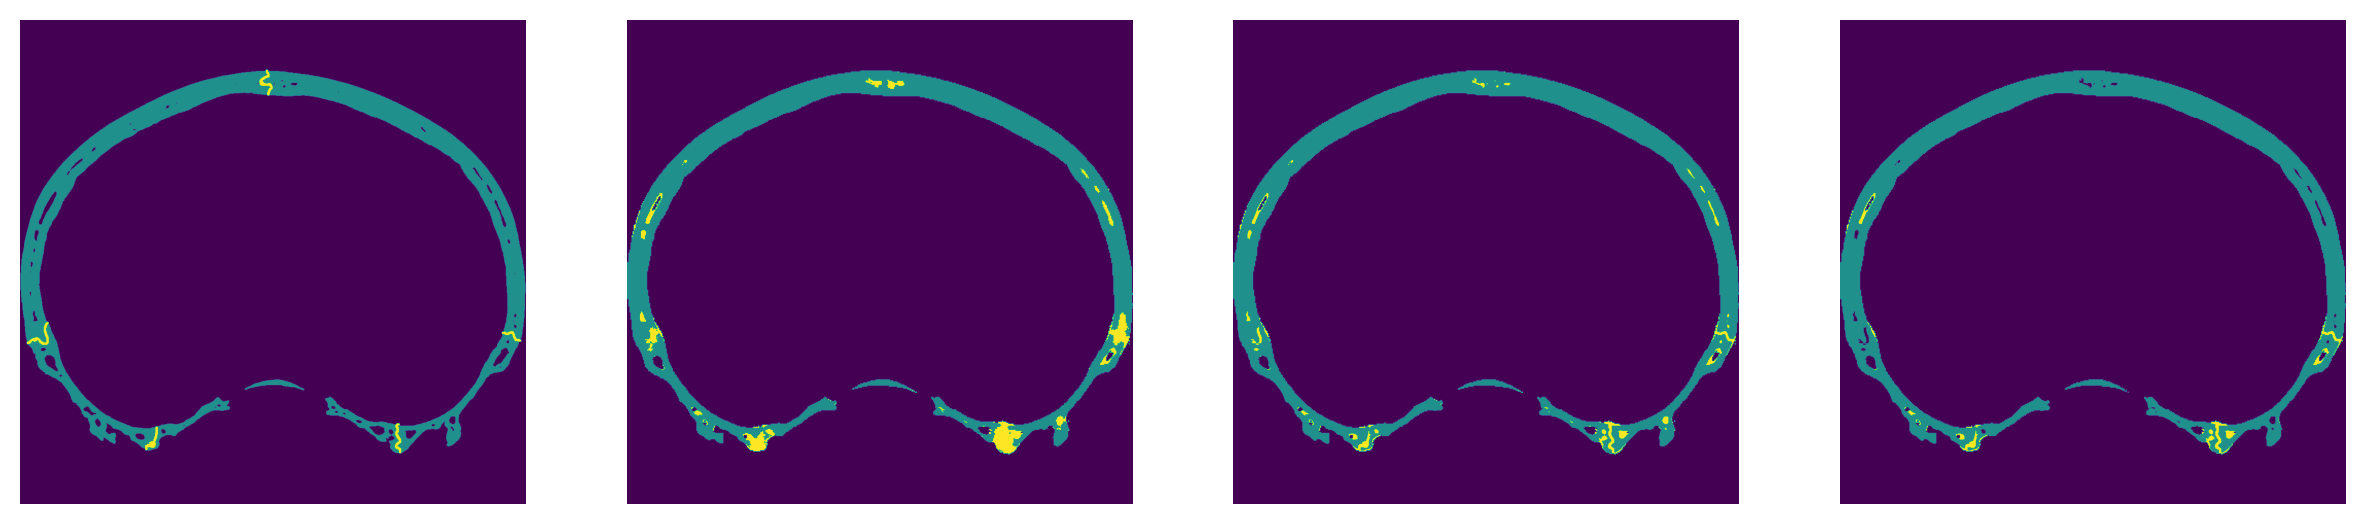

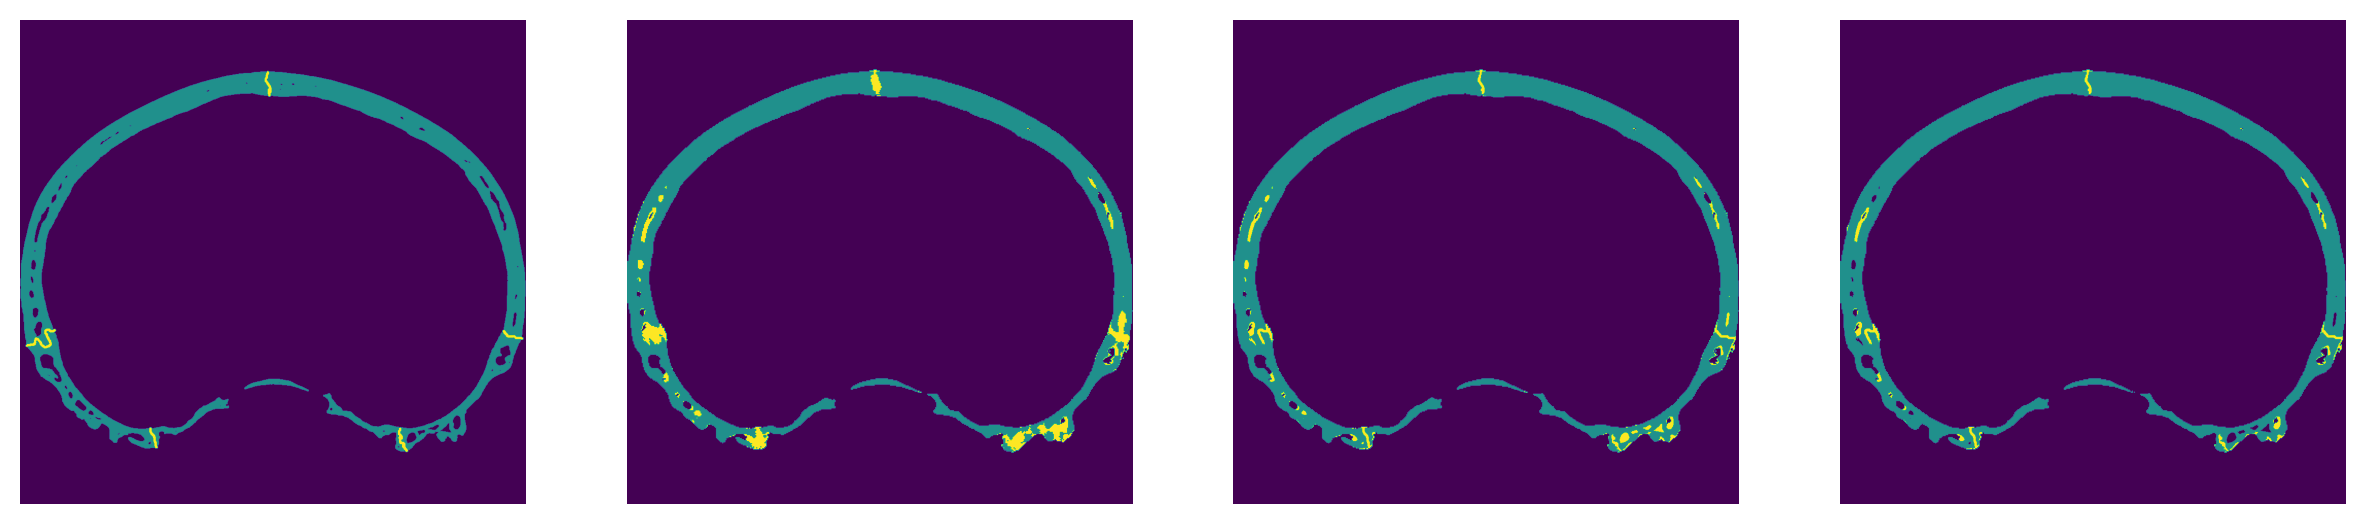

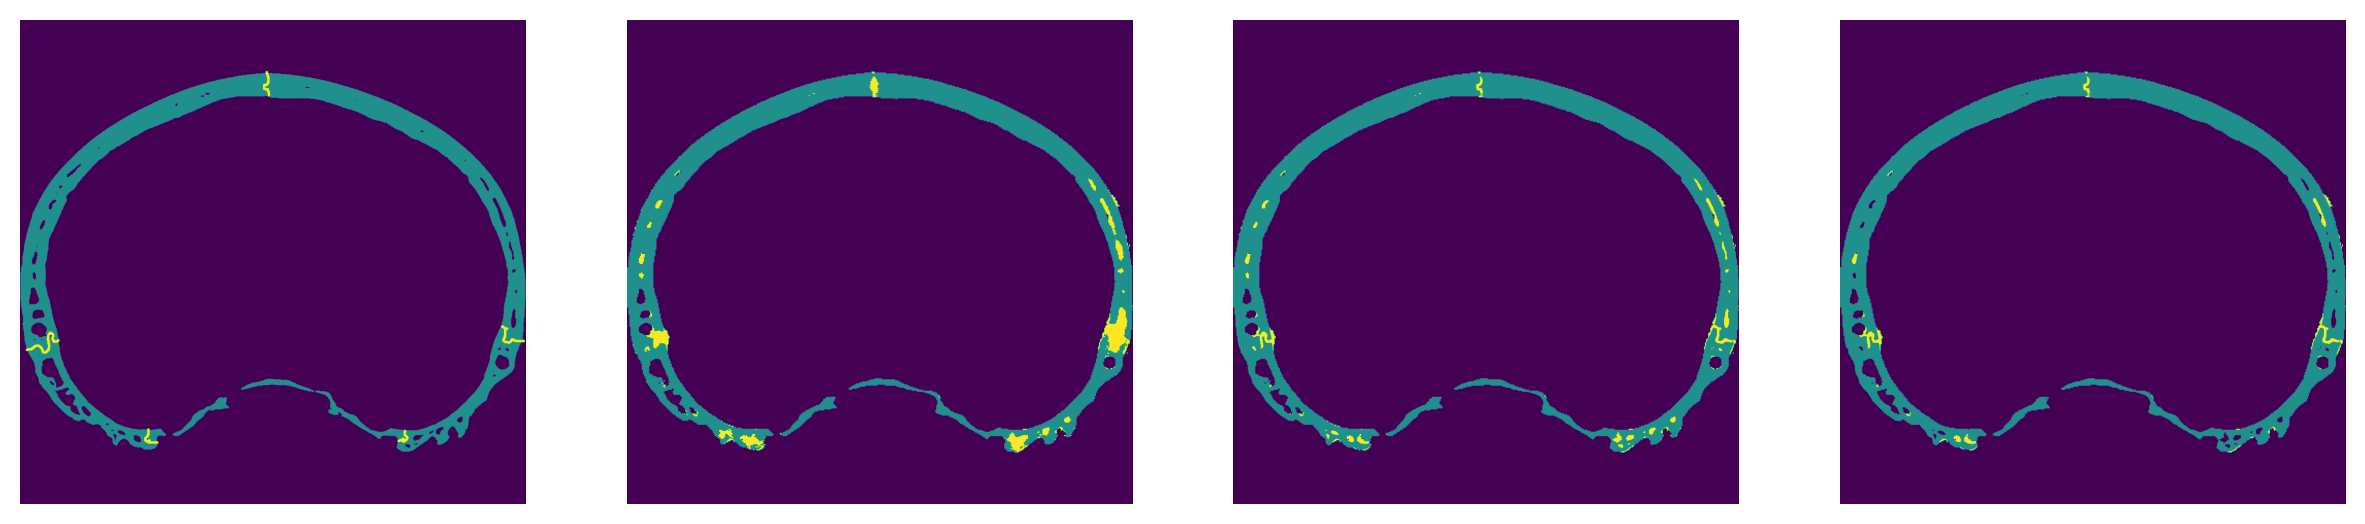

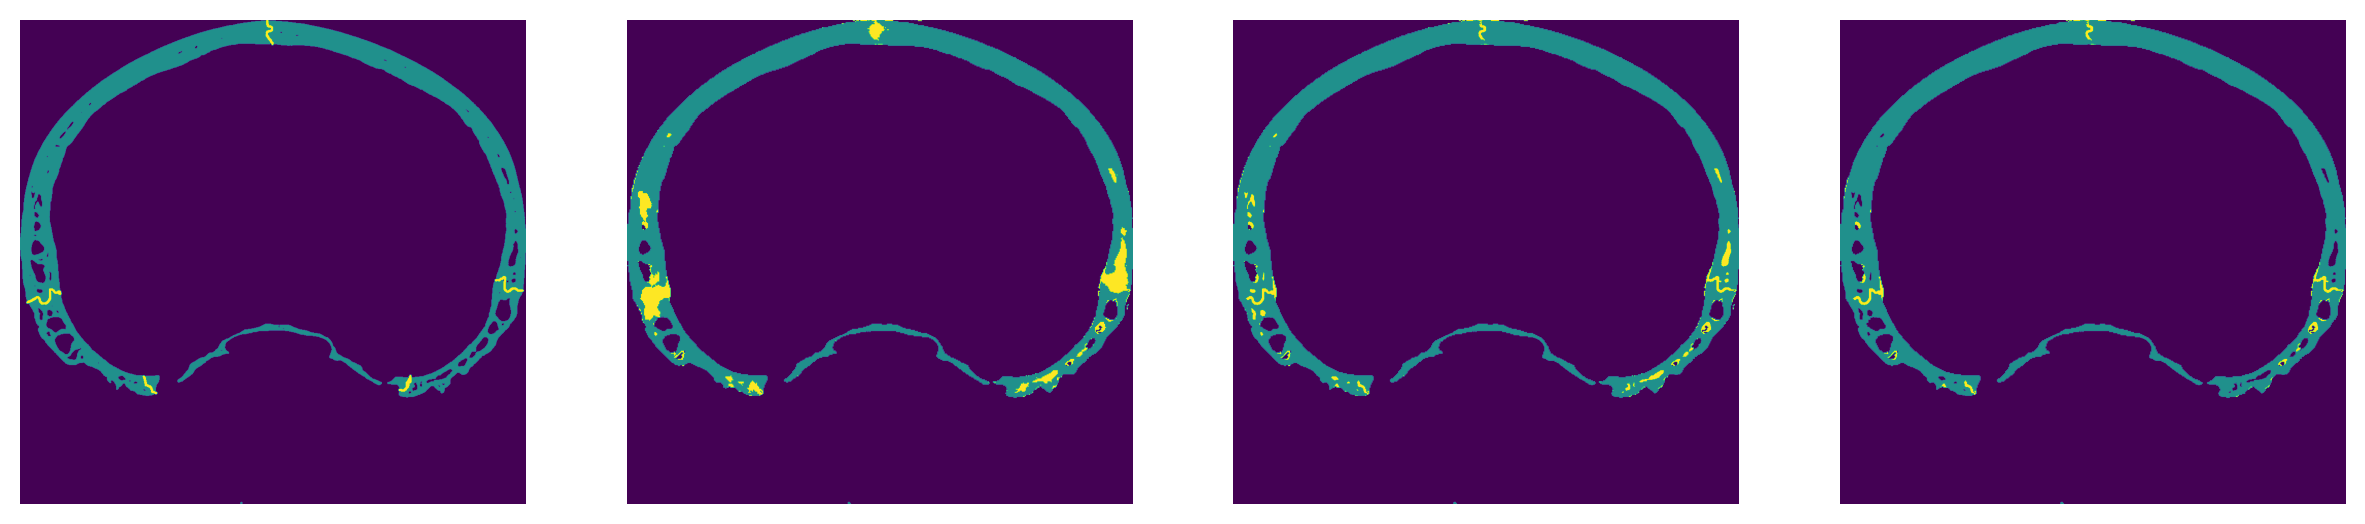

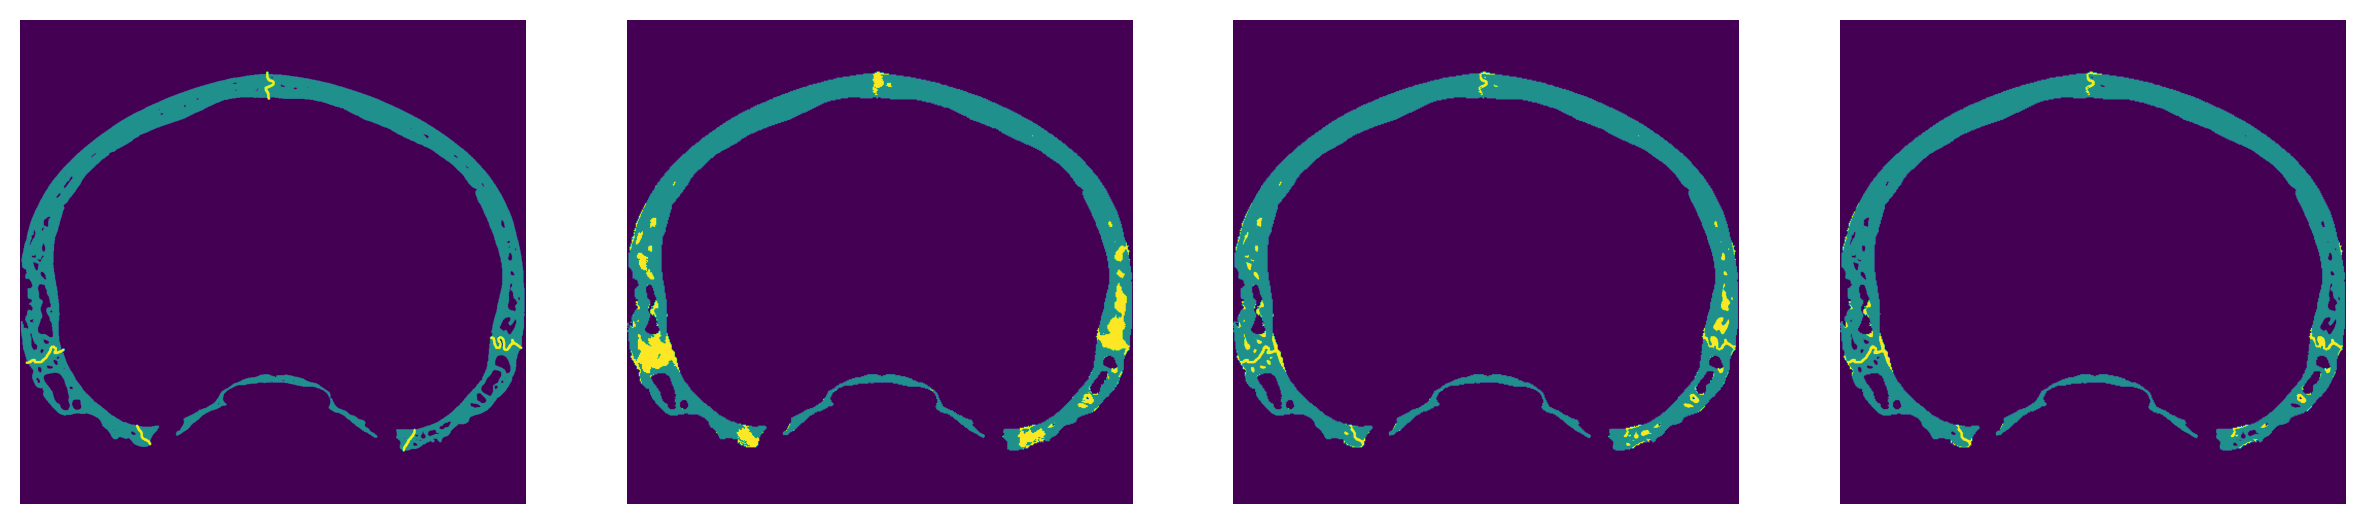

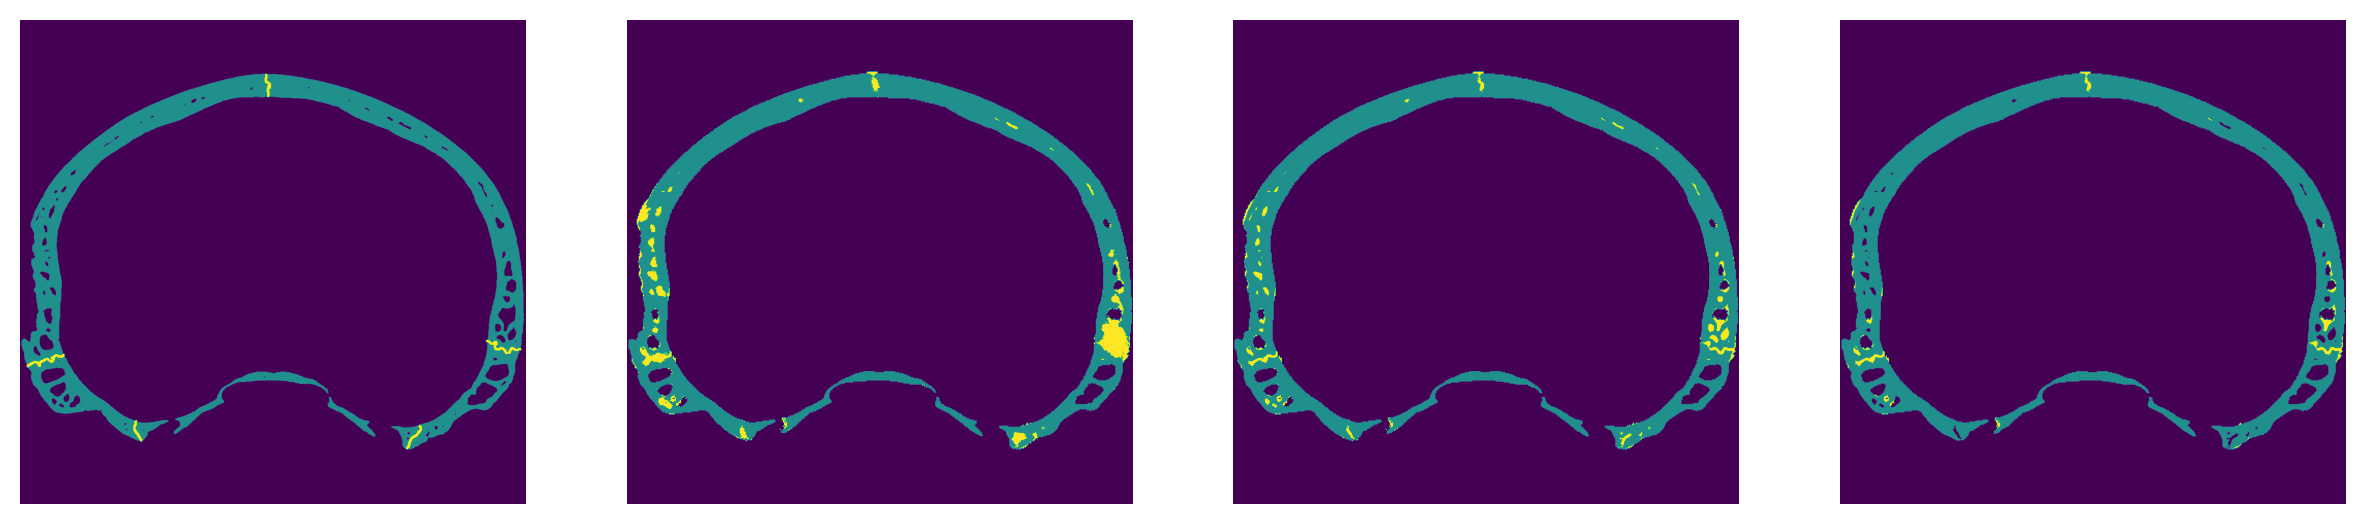

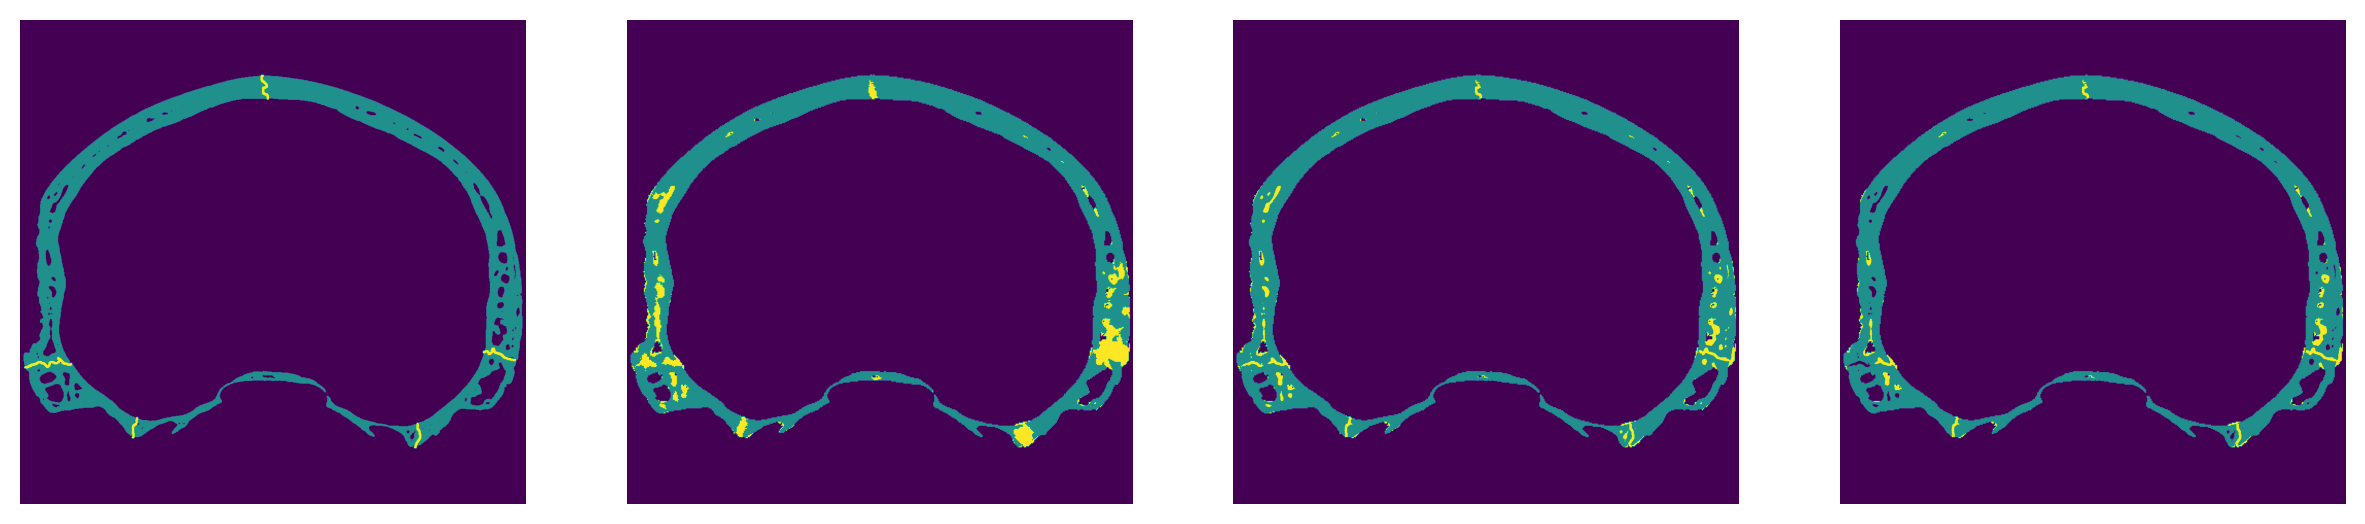

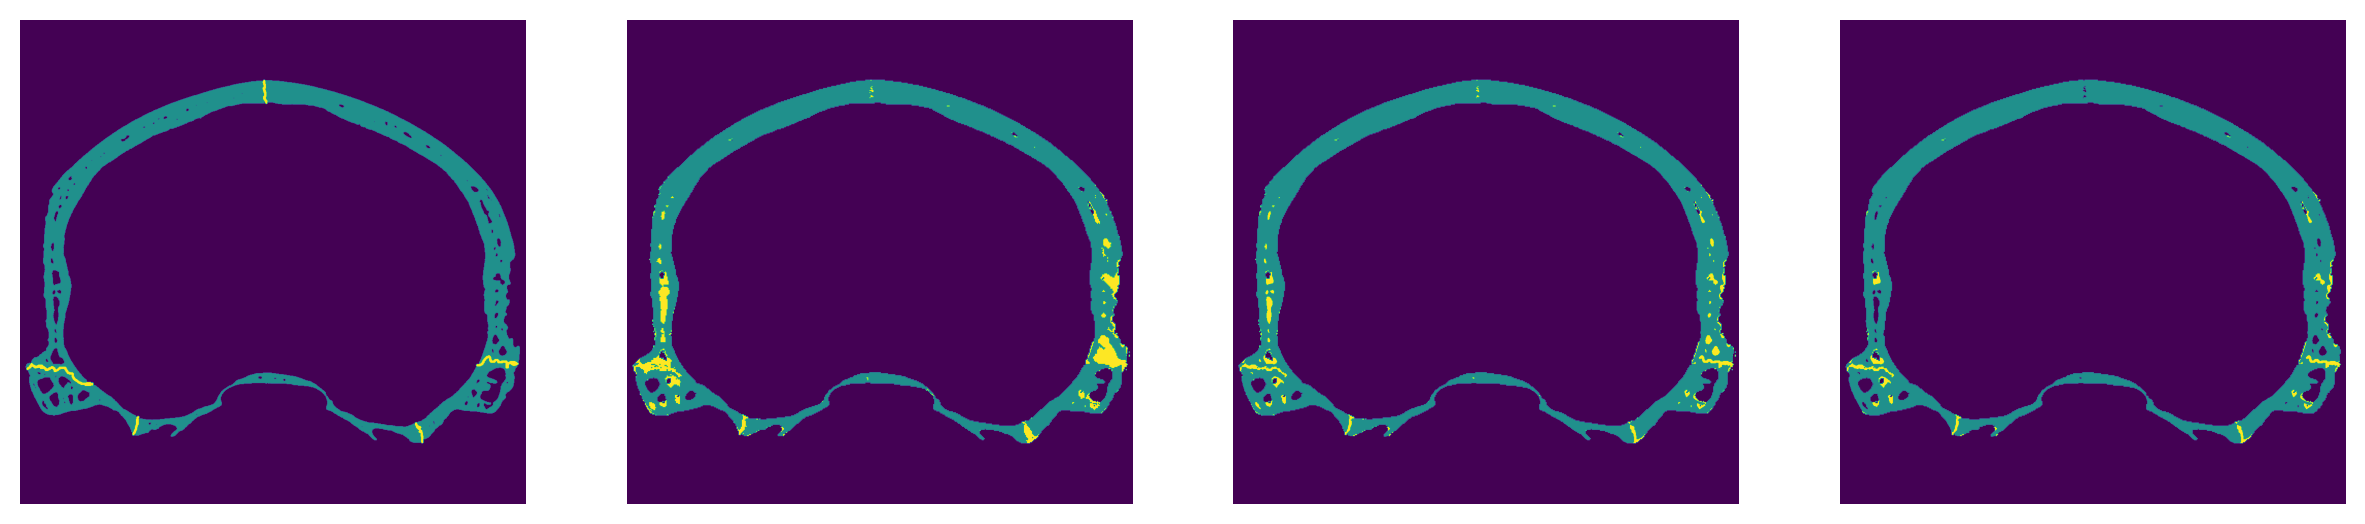

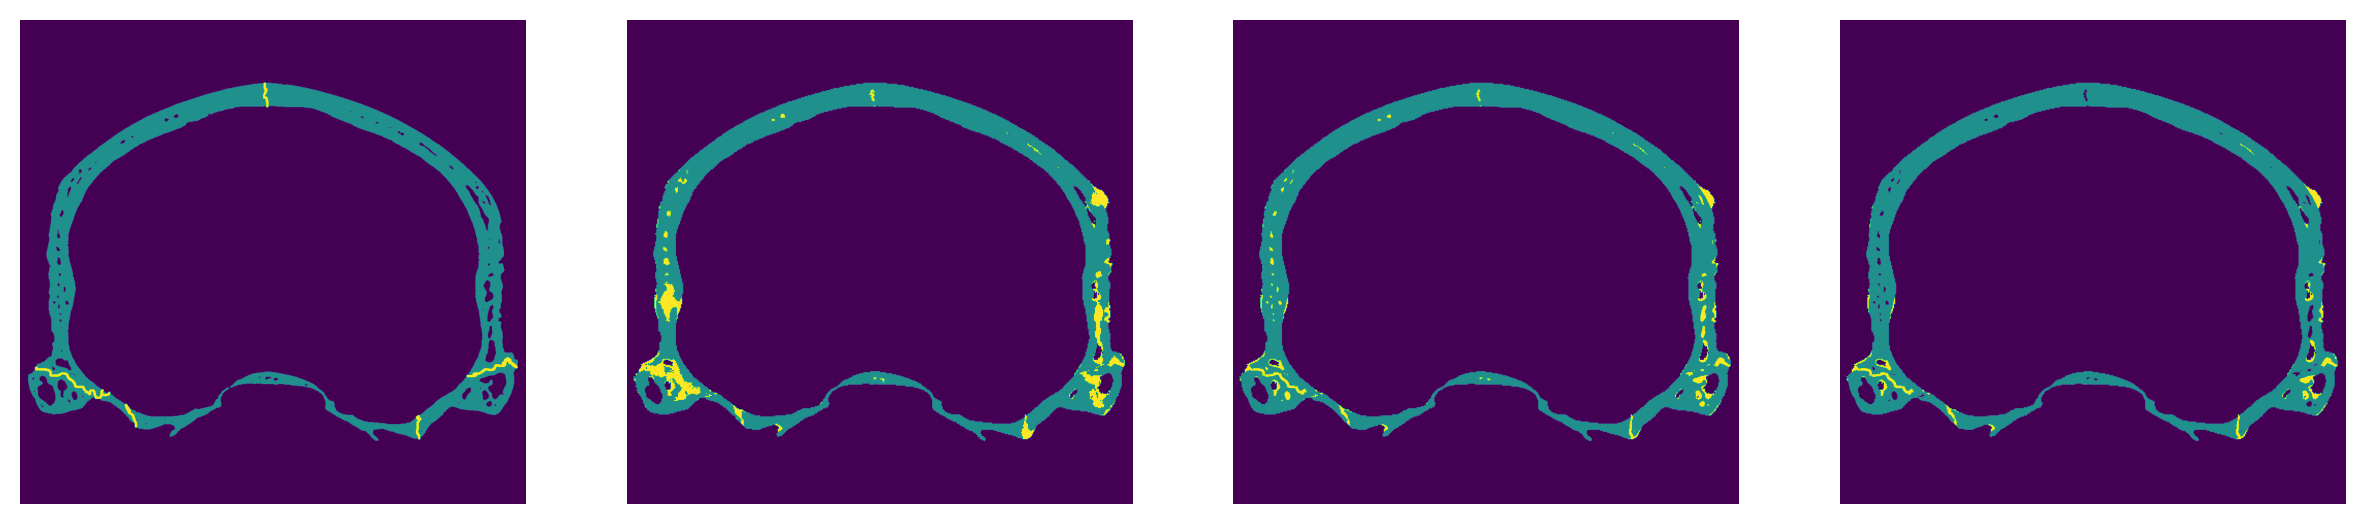

In [ ]:
## post_process the masks ##
# Use predicted bones which should be more accurately predicted
# To updated the sutures, which can often have the suture location correctly, but having thicker area than the actual one
# Use the bones to refine the suture predictions

mask_dir = "output/suture_demo_cy/"

bone_mask_dir = "data/suture_demo_data/cy_mask/"

gt_mask_dir = "data/suture_demo_data/cy_mask/"
# new_dir= "data/training_suture/mask/"
# Path(new_dir).mkdir(parents=True, exist_ok=True)

files = os.listdir(mask_dir)
iou_results = np.zeros((len(files),3))
for idx, file in enumerate(files):
    mask = cv2.imread(os.path.join(mask_dir , file), cv2.IMREAD_GRAYSCALE )
    

    
    gt_mask = cv2.imread(os.path.join(gt_mask_dir , file), cv2.IMREAD_GRAYSCALE)
    
    bone_mask = cv2.imread(os.path.join(bone_mask_dir , file), cv2.IMREAD_GRAYSCALE)
    bone_mask = bone_mask==1
    
    new_mask = mask.copy()
    
    new_mask[bone_mask==1] =1
    
    
    not_in_holes = remove_inner_bone_area((new_mask == 2).astype('uint8'),new_mask ,10)
    not_in_holes_result = refine_with_not_in_bone_masks(new_mask,not_in_holes,class_value=2)
    
    
    iou_results[idx , 0] = dice_score(gt_mask == 2, mask == 2)
    iou_results[idx , 1] = dice_score(gt_mask == 2, new_mask == 2)
    iou_results[idx , 2] = dice_score(gt_mask == 2, not_in_holes_result == 2)
    
    fig = plt.figure(figsize=(15, 5), dpi=200)

    

    ax1 = fig.add_subplot(1, 4, 1)  # equivalent but more general
    ax1.axis('off')
    ax1.imshow(gt_mask)
    
    ax1 = fig.add_subplot(1, 4,2)  # equivalent but more general
    ax1.axis('off')
    ax1.imshow(mask)
    
    ax1 = fig.add_subplot(1, 4, 3)  # equivalent but more general
    ax1.axis('off')
    ax1.imshow(new_mask)


    ax1 = fig.add_subplot(1, 4, 4)  # equivalent but more general
    ax1.axis('off')
    ax1.imshow(not_in_holes_result)
    
    # if old_values is None or new_values is None:
    #     old_values = np.unique(mask)
    #     new_values = list(range(0, len(old_values)))
    
    plt.savefig("plots/1specimen/{}.png".format(idx))

plt.violinplot(iou_results)


{'bodies': [<matplotlib.collections.PolyCollection at 0x2078fcd4160>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x2078fcd4040>,
 'cmins': <matplotlib.collections.LineCollection at 0x20780208880>,
 'cbars': <matplotlib.collections.LineCollection at 0x20780208250>}

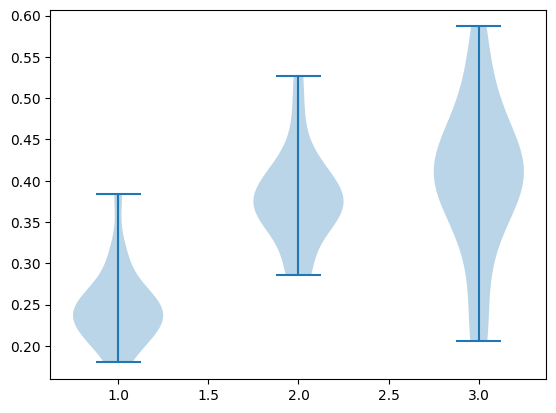

In [ ]:
plt.violinplot(iou_results)

{'bodies': [<matplotlib.collections.PolyCollection at 0x20781a2f5b0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x207be568d90>,
 'cmins': <matplotlib.collections.LineCollection at 0x2078035beb0>,
 'cbars': <matplotlib.collections.LineCollection at 0x20780359630>}

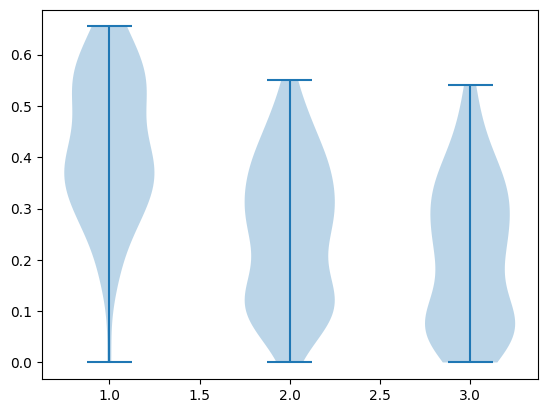

In [ ]:
plt.violinplot(iou_results)

In [ ]:
# remove predicted suture areas ( connected components) that are completely inside the bone predictions.

## post_process the masks ##
# Use predicted bones which should be more accurately predicted
# To updated the sutures, which can often have the suture location correctly, but having thicker area than the actual one
# Use the bones to refine the suture predictions

mask_dir = "output/suture_demo_cy/"

bone_mask_dir = "data/suture_demo_data/cy_mask/"


# new_dir= "data/training_suture/mask/"
# Path(new_dir).mkdir(parents=True, exist_ok=True)

files = os.listdir(mask_dir)
iou_results = np.zeros((len(files),2))
for idx, file in enumerate(files):
    mask = cv2.imread(os.path.join(mask_dir , file), cv2.IMREAD_GRAYSCALE )
    
    suture_mask = (mask==2).astype("uint8")

    
    gt_mask = cv2.imread(os.path.join(bone_mask_dir , file), cv2.IMREAD_GRAYSCALE)
    
    bone_mask = (gt_mask==1)
    
    new_mask = mask.copy()
    

    



In [ ]:

# suture_mask


# # Find all connected components in the mask
# num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(suture_mask)

# # Print the number of connected components found
# print('Number of connected components:', num_labels - 1)

# # Loop through each connected component and draw a bounding box around it
# for i in range(1, num_labels):
#     x, y, w, h, area = stats[i]
#     cv2.rectangle(mask, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
# # cv2.imshow('Connected components', mask)

# plt.imshow(suture_mask)

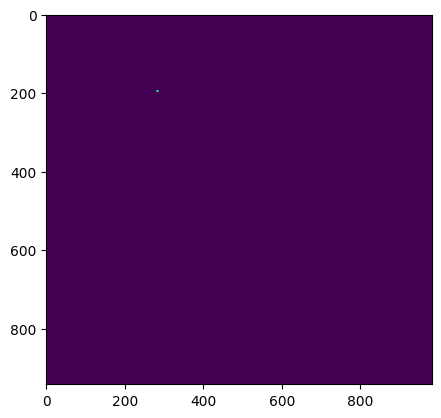

In [ ]:
# Load the binary mask image
# mask = cv2.imread('mask.png', cv2.IMREAD_GRAYSCALE)

# Find the connected components in the mask
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(suture_mask)

# Create an array to hold the connected component masks
masks = np.zeros((num_labels - 1, mask.shape[0], mask.shape[1]), dtype=np.uint8)

# Loop through each connected component and extract its mask
for i in range(1, num_labels):
    component_mask = np.zeros(mask.shape, dtype=np.uint8)
    component_mask[labels == i] = 255
    masks[i - 1] = component_mask

plt.imshow(masks[3])

# Display the masks
# for i in range(num_labels - 1):
#     cv2.imshow(f'Connected Component {i}', masks[i])

number of connected component: 46
not inside:  False
not inside:  False
not inside:  False
not inside:  True
not inside:  False
not inside:  True
not inside:  False
not inside:  True
not inside:  True
not inside:  False
not inside:  True
not inside:  True
not inside:  False
not inside:  True
not inside:  False
not inside:  True
not inside:  False
not inside:  False
not inside:  True
not inside:  False
not inside:  True
not inside:  True
not inside:  True
not inside:  True
not inside:  True
not inside:  True
not inside:  True
not inside:  True
not inside:  True
not inside:  True
not inside:  False
not inside:  True
not inside:  True
not inside:  False
not inside:  False
not inside:  True
not inside:  True
not inside:  True
not inside:  True
not inside:  True
not inside:  False
not inside:  True
not inside:  True
not inside:  True
not inside:  True
not inside:  True


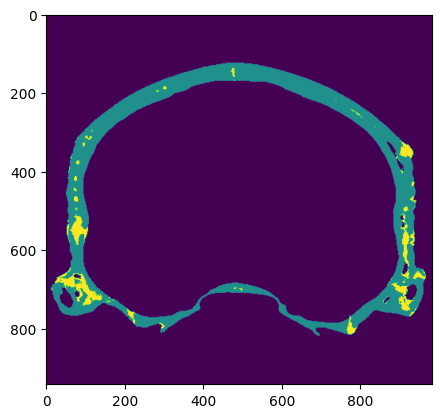

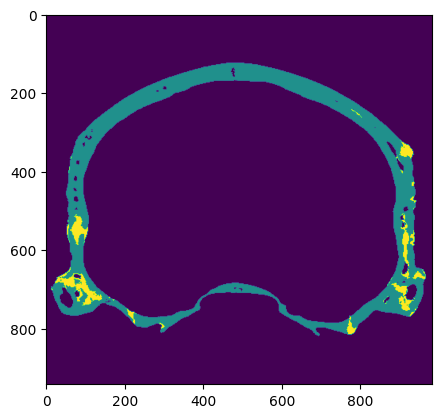

In [ ]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(suture_mask)
plt.imshow(mask)
# Create an array to hold the connected component masks
# masks = np.zeros((num_labels - 1, mask.shape[0], mask.shape[1]), dtype=np.uint8)
masks = []
# Loop through each connected component and extract its mask
for i in range(1, num_labels):
    component_mask = np.zeros(mask.shape, dtype=np.uint8)
    component_mask[labels == i] = 255
    component_size = stats[i, cv2.CC_STAT_AREA]
    if component_size >= 10:
        masks.append(component_mask)

print("number of connected component:" , len(masks))
not_in_bone_masks = []
for cc in masks:
    # cc = masks[8]
    size = 3
    idxs = np.where(cc ==255)

    neighbors_all = []
    for row,col in zip(idxs[0],idxs[1]) :
        
        # print(type(row),col)
        # Extract the rectangular region around the pixel
        subimg = cv2.getRectSubPix(mask, (size,size) , (int(col),int(row)))

        # Get the neighboring pixels as a 1D array
        neighbors = subimg.flatten()

        # Remove the center pixel from the array of neighboring pixels
        neighbors = np.delete(neighbors, size**2//2)
        neighbors_all = np.concatenate((neighbors_all , neighbors))
    print("not inside: ",np.any(neighbors_all==0))
    if np.any(neighbors_all==0):
        not_in_bone_masks.append(cc)
        

mask[mask ==2]=0

for not_in_bone_mask in not_in_bone_masks:
    mask[not_in_bone_mask ==255]=2

# print(len(masks))
# plt.imshow(masks[8])
plt.figure()
plt.imshow(mask)


# mask[masks[8] ==255]


In [ ]:
# print(np.where(masks[8] ==255))

# mask[294,115]





In [ ]:
np.any(neighbors==1)
np.all(neighbors==1)
np.where(masks[8] ==255)

(array([362, 362, 363, 363, 364, 364, 365, 365, 366, 366, 366, 366, 367,
        367, 367, 367], dtype=int64),
 array([63, 64, 63, 64, 63, 64, 63, 64, 61, 62, 63, 64, 61, 62, 63, 64],
       dtype=int64))

In [ ]:

neighbors.

SyntaxError: invalid syntax (2047237189.py, line 1)